# Deep Q Network with Prioritized Experience Replay

## Imports

In [1]:
import gym, math, glob, random
import numpy as np

from timeit import default_timer as timer
from datetime import timedelta

import torch
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from utils.wrappers import *
from agents.DQN import Model as DQN_Agent
from utils.ReplayMemory import ExperienceReplayMemory

from utils.hyperparameters import Config
from utils.plot import plot_all_data
from utils.data_structures import SegmentTree, MinSegmentTree, SumSegmentTree

## Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = config.device

#epsilon variables
config.epsilon_start = 1.0
config.epsilon_final = 0.01
config.epsilon_decay = 30000
config.epsilon_by_frame = lambda frame_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)

#misc agent variables
config.GAMMA=0.99
config.LR=1e-4

#memory
config.TARGET_NET_UPDATE_FREQ = 1000
config.EXP_REPLAY_SIZE = 100000
config.BATCH_SIZE = 32
config.PRIORITY_ALPHA=0.6
config.PRIORITY_BETA_START=0.4
config.PRIORITY_BETA_FRAMES = 100000

#Learning control variables
config.LEARN_START = 10000
config.MAX_FRAMES=1000000
config.UPDATE_FREQ = 1

#Nstep controls
config.N_STEPS=1

#data logging parameters
config.ACTION_SELECTION_COUNT_FREQUENCY = 1000

## Prioritized Replay (Without Rank-Based Priority)

In [3]:
class PrioritizedReplayMemory(object):
    def __init__(self, size, alpha=0.6, beta_start=0.4, beta_frames=100000):
        super(PrioritizedReplayMemory, self).__init__()
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

        assert alpha >= 0
        self._alpha = alpha

        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame=1

        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def beta_by_frame(self, frame_idx):
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)

    def push(self, data):
        idx = self._next_idx

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize


        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _encode_sample(self, idxes):
        return [self._storage[i] for i in idxes]

    def _sample_proportional(self, batch_size):
        res = []
        for _ in range(batch_size):
            mass = random.random() * self._it_sum.sum(0, len(self._storage) - 1)
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size):
        idxes = self._sample_proportional(batch_size)

        weights = []

        #find smallest sampling prob: p_min = smallest priority^alpha / sum of priorities^alpha
        p_min = self._it_min.min() / self._it_sum.sum()

        beta = self.beta_by_frame(self.frame)
        self.frame+=1
        
        #max_weight given to smallest prob
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-beta)
            weights.append(weight / max_weight)
        weights = torch.tensor(weights, device=config.device, dtype=torch.float) 
        encoded_sample = self._encode_sample(idxes)
        return encoded_sample, idxes, weights

    def update_priorities(self, idxes, priorities):
        assert len(idxes) == len(priorities)
        for idx, priority in zip(idxes, priorities):
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = (priority+1e-5) ** self._alpha
            self._it_min[idx] = (priority+1e-5) ** self._alpha

            self._max_priority = max(self._max_priority, (priority+1e-5))

## Agent

In [4]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None, config=None, log_dir='/tmp/gym'):
        super(Model, self).__init__(static_policy, env, config, log_dir=log_dir)
    
    def declare_memory(self):
        self.memory = PrioritizedReplayMemory(self.experience_replay_size, self.priority_alpha, self.priority_beta_start, self.priority_beta_frames)
        
    def compute_loss(self, batch_vars): #faster
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        #estimate
        self.model.sample_noise()
        current_q_values = self.model(batch_state).gather(1, batch_action)
        
        #target
        with torch.no_grad():
            max_next_q_values = torch.zeros(self.batch_size, device=self.device, dtype=torch.float).unsqueeze(dim=1)
            if not empty_next_state_values:
                max_next_action = self.get_max_next_state_action(non_final_next_states)
                self.target_model.sample_noise()
                max_next_q_values[non_final_mask] = self.target_model(non_final_next_states).gather(1, max_next_action)
            expected_q_values = batch_reward + ((self.gamma**self.nsteps)*max_next_q_values)

        diff = (expected_q_values - current_q_values)
        self.memory.update_priorities(indices, diff.detach().squeeze().abs().cpu().numpy().tolist())
        loss = self.MSE(diff).squeeze() * weights
        loss = loss.mean()

        return loss

## Training Loop

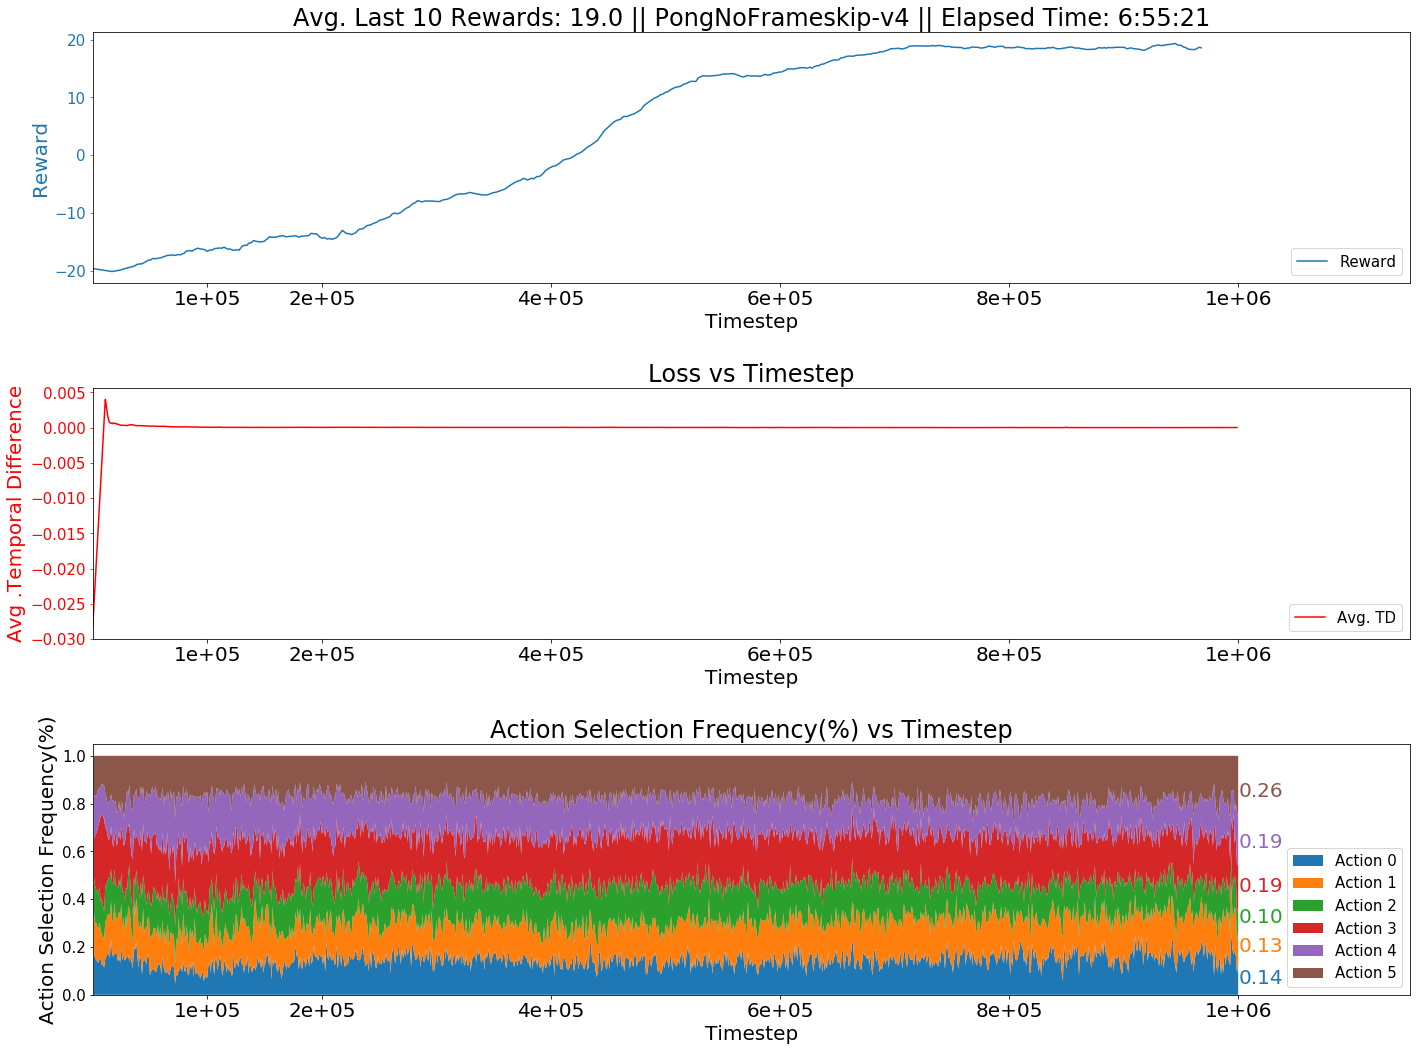

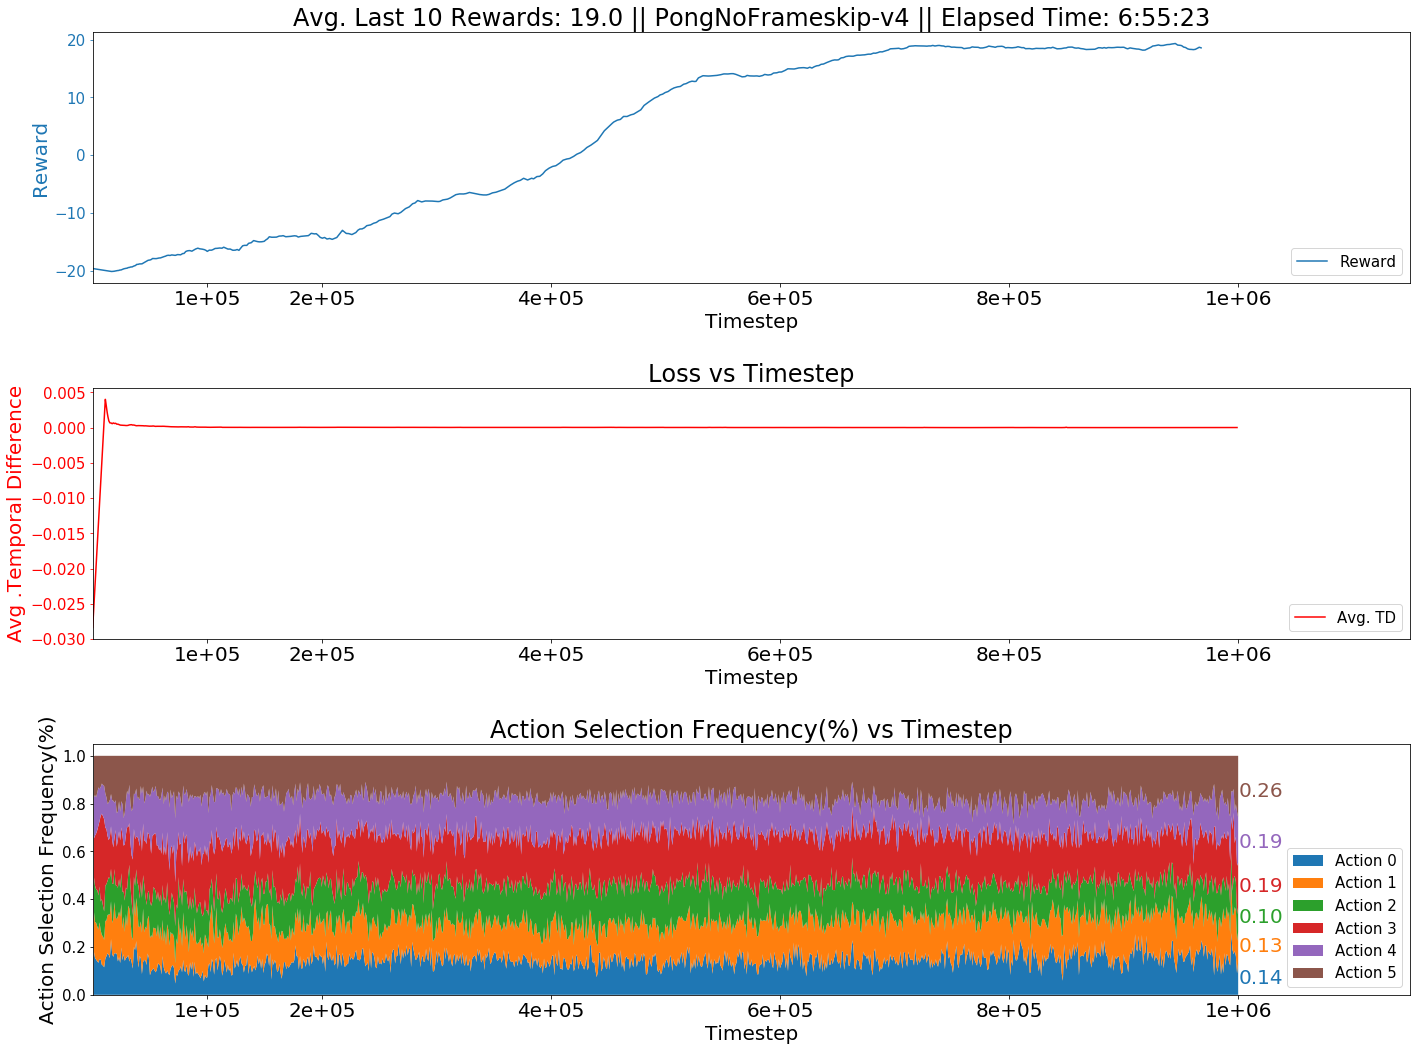

In [5]:
start=timer()

log_dir = "/tmp/gym/"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
        + glob.glob(os.path.join(log_dir, '*td.csv')) \
        + glob.glob(os.path.join(log_dir, '*sig_param_mag.csv')) \
        + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = bench.Monitor(env, os.path.join(log_dir, env_id))
env    = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=True)
env    = WrapPyTorch(env)
model  = Model(env=env, config=config, log_dir=log_dir)

episode_reward = 0

observation = env.reset()
for frame_idx in range(1, config.MAX_FRAMES + 1):
    epsilon = config.epsilon_by_frame(frame_idx)

    action = model.get_action(observation, epsilon)
    model.save_action(action, frame_idx) #log action selection

    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0

    if frame_idx % 10000 == 0:
        model.save_w()
        try:
            clear_output(True)
            plot_all_data(log_dir, env_id, 'PriorityDQN', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass

model.save_w()
env.close()
plot_all_data(log_dir, env_id, 'PriorityDQN', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)